# Evaluation

In [1]:
# Importing libraries
import torchio as tio
import glob
import numpy as np
import random
import os
import pickle

from collections import OrderedDict
from pathlib import Path

from tqdm import tqdm
import time

import torchio as tio
from torchio.transforms import (RescaleIntensity,RandomFlip,Compose, HistogramStandardization, CropOrPad)

from sklearn.metrics import accuracy_score,f1_score, recall_score, precision_score

from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from scipy.ndimage import zoom

from Functions_classification_training import UNet_1_layer, UNet_2_layer, Classifier

In [2]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import visualization as viz

## DataLoaders

In [3]:
with open('design_expl_classifier_training.pkl', 'rb') as f:
    design_expl_classifier_training = pickle.load(f)

In [14]:
design_expl_classifier_training['test']

{'ABIDE': {'control': ['A00032629',
   'A00032547',
   'A00032359',
   'A00032565',
   'A00032410',
   'A00032597',
   'A00033282',
   'A00032776',
   'A00032763',
   'A00033267',
   'A00032645',
   'A00032790',
   'A00032340',
   'A00032725',
   'A00032324',
   'A00032402',
   'A00033270',
   'A00033278',
   'A00033289',
   'A00032338',
   'A00033264',
   'A00032407',
   'A00032321',
   'A00032753',
   'A00032740',
   'A00032391',
   'A00032542',
   'A00032724',
   'A00032768',
   'A00032637',
   'A00032620',
   'A00032370',
   'A00032714',
   'A00032662',
   'A00032373',
   'A00032557']},
 'Athletes': {'control': ['053', '039', '036', '033', '030']},
 'HCP': {'control': ['175136',
   '601127',
   '421226',
   '117930',
   '947668',
   '255639',
   '161731',
   '200614',
   '518746',
   '668361',
   '789373',
   '125222',
   '173738',
   '765864',
   '773257',
   '645551',
   '130114',
   '901139',
   '147030',
   '172433',
   '227432',
   '397861',
   '192035',
   '166438',
   '49956

In [17]:
# Torchio's subjects' dictionary + upsample the albinism group, so it matches controls in train and dev_train + add labels

dict_expl_classifier_training={}

for group in design_expl_classifier_training.keys():
    
    dict_expl_classifier_training[group]=[]
    
    # Calculate the number of albinism and controls, calculate the scaling coefficient
    num_control=0
    num_albinism=0
    
    for dataset in design_expl_classifier_training[group].keys():
            
        num_control+=len(design_expl_classifier_training[group][dataset]['control'])
        
        if dataset in ['CHIASM', 'UoN']:
            num_albinism+=len(design_expl_classifier_training[group][dataset]['albinism'])
    
    scaling_factor=int(num_control/num_albinism)
    
    # Create Torchio's subject for listed IDs, for train & dev_train upsample the albinism
    for dataset in design_expl_classifier_training[group].keys():
        
        # If test just aggregate all the data
        if group=='test':
             
            for label in design_expl_classifier_training[group][dataset].keys():
               
               if label=='albinism':
                   label_as=1
               elif label=='control':
                   label_as=0
               
               dict_expl_classifier_training[group]+=[tio.Subject(chiasm=tio.Image('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz', type=tio.INTENSITY),
                                                                   label=label_as) for subject in design_expl_classifier_training[group][dataset][label]]
    
            if dataset in ['CHIASM','UoN']:
    
                for label in design_expl_classifier_training[group][dataset].keys():
    
                    if label=='albinism':
                        label_as=1
                    elif label=='control':
                        label_as=0
                        
                    dict_expl_classifier_training[group]+=[tio.Subject(chiasm=tio.Image('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz', type=tio.INTENSITY),
                                                             label=label_as) for subject in design_expl_classifier_training[group][dataset][label]]
    
        # otherwise upsample albinism by calculated scaling_factor
        else:
            
            for label in design_expl_classifier_training[group][dataset].keys():
                
                if label=='control':
                    
                    label_as=0
                    
                    dict_expl_classifier_training[group]+=[tio.Subject(chiasm=tio.Image('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz', type=tio.INTENSITY),
                                                                    label=label_as) for subject in design_expl_classifier_training[group][dataset][label]]
    
                if label=='albinism':
                    
                    label_as=1
                    
                    for i in range(scaling_factor):
                    
                        dict_expl_classifier_training[group]+=[tio.Subject(chiasm=tio.Image('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz', type=tio.INTENSITY),
                                                                        label=label_as) for subject in design_expl_classifier_training[group][dataset][label]]    

In [20]:
# Histogram standardization (to mitigate cross-site differences)
chiasm_paths=[]

# Obtain paths of all chiasm images
for group in design_expl_classifier_training.keys():
    for dataset in design_expl_classifier_training[group].keys():
        for label in design_expl_classifier_training[group][dataset].keys():
            for subject in design_expl_classifier_training[group][dataset][label]:
                chiasm_paths.append('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz')

chiasm_landmarks_path = Path('chiasm_landmarks.npy')    

chiasm_landmarks = HistogramStandardization.train(chiasm_paths)
torch.save(chiasm_landmarks, chiasm_landmarks_path)

landmarks={'chiasm': chiasm_landmarks}

standardize = HistogramStandardization(landmarks)

100%|█████████████████████████████████████| 1740/1740 [00:01<00:00, 1006.98it/s]


In [21]:
# Data preprocessing and augmentation

# Rescale
rescale = RescaleIntensity((0,1))

crop = CropOrPad((24,24,8))

# Composing transforms - flip serves as data augmentation and is used only for training
transform = Compose([standardize, rescale, crop])

In [22]:
datasets_list={}

for group in dict_expl_classifier_training.keys():
    
        datasets_list[group] = tio.SubjectsDataset(dict_expl_classifier_training[group], transform=transform)

In [23]:
# Create dataloaders
dataloaders_chiasm={'train': DataLoader(dataset=datasets_list['train'], batch_size=10, shuffle=True, num_workers=8),
                   'dev_train': DataLoader(dataset=datasets_list['dev_train'], batch_size=10, shuffle=True, num_workers=8),
                   'test': DataLoader(dataset=datasets_list['test'], batch_size=10, shuffle=True, num_workers=8)}


train


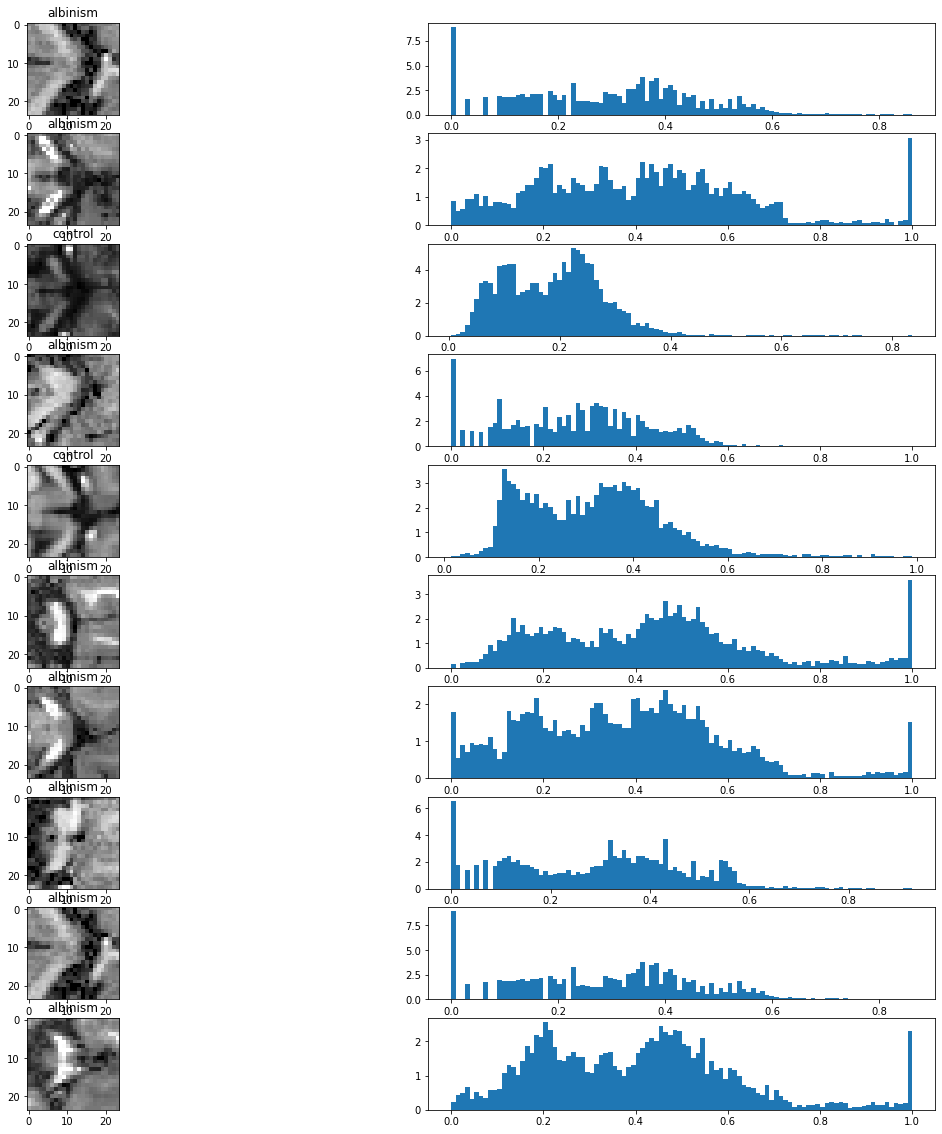

dev_train


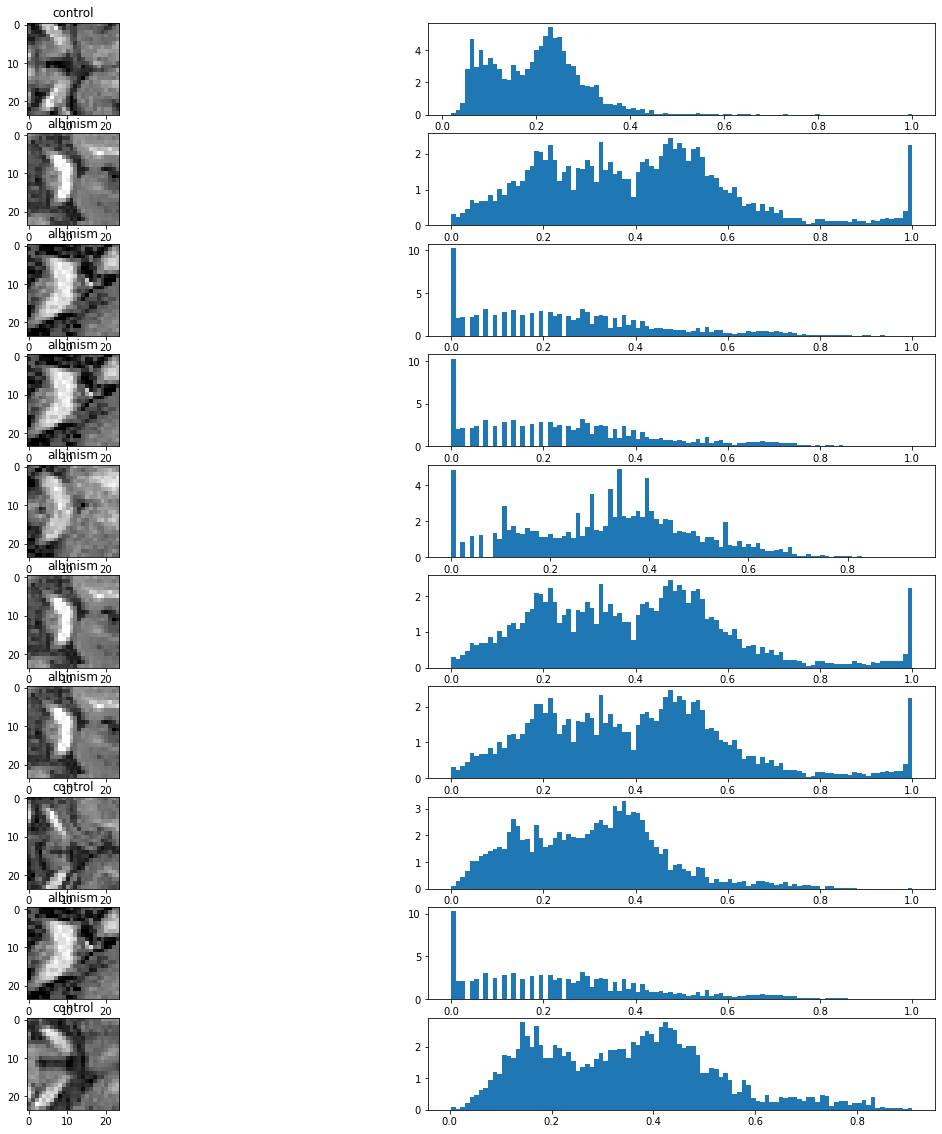

test


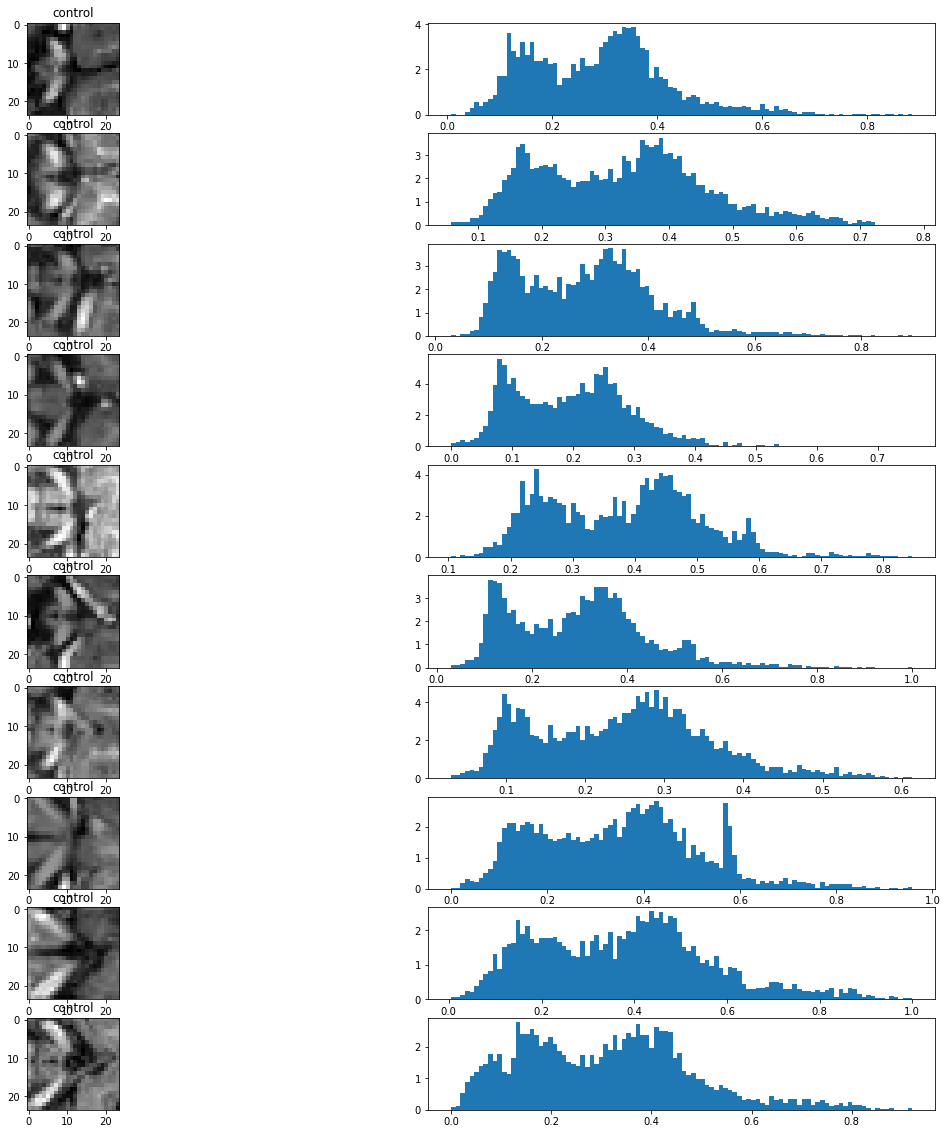

In [24]:
# Visualize results
classes=['control','albinism','other']

for group in ['train', 'dev_train', 'test']:
    
    print(group)
    
    batch = next(enumerate(dataloaders_chiasm[group]))
    
    data = batch[1]['chiasm']['data']
    labels = batch[1]['label']
    
    inputs = data.cpu().numpy()

        
    fig = plt.figure(figsize=(20,20))
    
    for i in range(inputs.shape[0]):
        
        plt.subplot(inputs.shape[0],2,2*i+1)
        plt.imshow(inputs[i,0,:,:,5],cmap='gray');
        plt.title(classes[labels[i]])    
        plt.subplot(inputs.shape[0],2,2*i+2)
        plt.hist(inputs[i,0].reshape(-1),density=True, bins=100);
        plt.axis('on')
    
    plt.show()

# Performance evaluation

In [25]:
def evaluate_accuracy(folder_with_networks, dataloader, dataset, group_to_be_evaluated):
    
    criterion = nn.NLLLoss(reduction='sum')
    
    names=[]
    loss=[]
    accuracy=[]
    f1=[]
    precision=[]
    recall=[]
    
    networks = [os.path.basename(x[0]) for x in os.walk(folder_with_networks)]
    networks=networks[1:]
     
    for network in networks:

        # Create network and load the weights
        params=network.split('_')
        
        model = Classifier(int(params[0]),int(params[1]),int(params[2]),int(params[3]), int(params[4]))
        model.load_state_dict(torch.load(folder_with_networks+network+'/optimal_weights'))

        # Evaluate the network on desired dataset
        tmp_loss=0.0
        tmp_targets=[]
        tmp_pred=[]
        
        for batch in dataloader[group_to_be_evaluated]:
            
            data=batch['chiasm']['data']
                        
            with torch.no_grad():
                
                output = model(data)
                
                tmp_loss +=(criterion(output.squeeze(),batch['label']).item())

                tmp_targets+=batch['label'][:].numpy().tolist()
                tmp_pred+=output.round().cpu().detach().numpy().tolist()

        names.append(network)
        loss.append(tmp_loss/len(dataset[group_to_be_evaluated]))
        accuracy.append(accuracy_score(tmp_targets,tmp_pred))
        f1.append(f1_score(tmp_targets,tmp_pred, average='weighted'))
        precision.append(precision_score(tmp_targets,tmp_pred, average='weighted'))
        recall.append(recall_score(tmp_targets,tmp_pred, average='weighted'))
        
    # Return the list with results
    return names,loss,accuracy, f1, precision,recall

In [26]:
def plot_training(path_to_saved_output, arch_name):
    
    with open(path_to_saved_output+'train_loss.pkl', 'rb') as f:
        train_loss=pickle.load(f)

    with open(path_to_saved_output+'dev_train_loss.pkl', 'rb') as f:
        dev_train_loss=pickle.load(f)

    with open(path_to_saved_output+'test_loss.pkl', 'rb') as f:
        dev_test_loss=pickle.load(f)

    with open(path_to_saved_output+'train_f1.pkl', 'rb') as f:
        train_f1=pickle.load(f)

    with open(path_to_saved_output+'dev_train_f1.pkl', 'rb') as f:
        dev_train_f1=pickle.load(f)

    with open(path_to_saved_output+'test_f1.pkl', 'rb') as f:
        test_f1=pickle.load(f)
                
    fig = plt.figure(figsize=(20,5))
    #plt.suptitle(os.path.basename(path_to_saved_output))
    plt.suptitle('Training progress for architecture '+arch_name)
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, label='train')
    plt.plot(dev_train_loss, label='train_dev')
    plt.plot(dev_test_loss, label='test')
    plt.legend();
    plt.ylabel('Loss');
    plt.xlabel('Epoch')
    
    plt.subplot(1,2,2)
    plt.plot(train_f1, label='train')
    plt.plot(dev_train_f1, label='train_dev')
    plt.plot(test_f1, label='test')
    plt.legend();
    plt.ylabel('Accuracy');
    plt.xlabel('Epoch')

In [27]:
def plot_evaluation(names_list, loss_list, acc_list, f1_list, precision_list, recall_list, name):
    
    # order lists
    acc_list, loss_list, names_list, f1_list, precision_list, recall_list = (list(t) for t in zip(*sorted(zip(acc_list, loss_list, names_list, f1_list, precision_list, recall_list))))
    
    # plot with subplots
    fig = plt.figure(figsize=(16,12))
    #plt.suptitle(name)
    
    # Cross-entropy loss
#     ax1 = plt.subplot(511)
#     plt.scatter(names_list, loss_list)
#     plt.xticks(rotation=90);
#     plt.axhline(y=-0.5, color='r', linestyle='--')
#     plt.ylim([-1,0])
#     ax1.axes.get_xaxis().set_ticks([])
#     plt.title('Losses')
    
    # Accuracy
    ax2 = plt.subplot(411)
    plt.scatter(names_list, acc_list)
    plt.xticks(rotation=90);
    plt.axhline(y=0.9, color='r', linestyle='--')
    plt.ylim([0.4,1.05])
    plt.ylabel('Accuracy')
    plt.title('Results of search for optimal classifying module')
    ax2.axes.get_xaxis().set_ticks([])
    
    # Precision
    ax2 = plt.subplot(412)
    plt.scatter(names_list, precision_list)
    plt.xticks(rotation=90);
    plt.axhline(y=0.9, color='r', linestyle='--')
    plt.ylim([0.4,1.05])
    ax2.axes.get_xaxis().set_ticks([])
    plt.ylabel('Precision')
    
    # Recall
    ax2 = plt.subplot(413)
    plt.scatter(names_list, recall_list)
    plt.xticks(rotation=90);
    plt.axhline(y=0.9, color='r', linestyle='--')
    plt.ylim([0.4,1.05])
    plt.ylabel('Recall')
    #ax2.axes.get_xaxis().set_ticks([])

    
    # F1 score
#     ax3 = plt.subplot(515)
#     plt.scatter(names_list, f1_list)
#     plt.xticks(rotation=90);
#     plt.axhline(y=0.9, color='r', linestyle='--')
#     plt.ylim([-0.05,1.05])
#     plt.title('F1-score')

## Accuracy

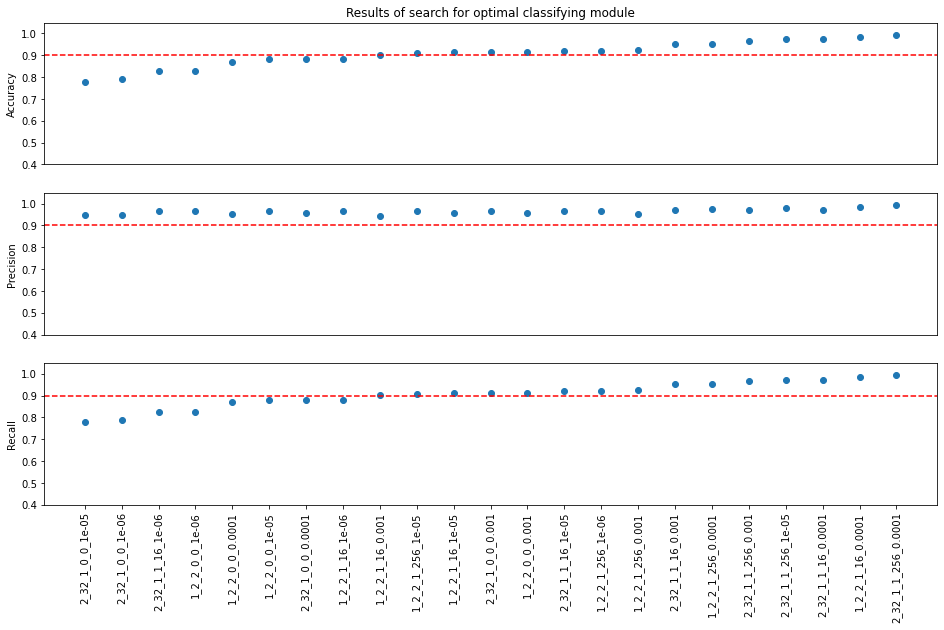

In [28]:
# Full retraining
plot_names, plot_loss, plot_accuracy, f1, precision, recall = evaluate_accuracy('../../1_Data/3_Trained_classifier_finetuning_classification/', dataloaders_chiasm, dict_expl_classifier_training, 'test')
plot_evaluation(plot_names, plot_loss, plot_accuracy, f1, precision, recall, 'Fine tuning classification')

## Training plots

1_2_2_0_0_0.001


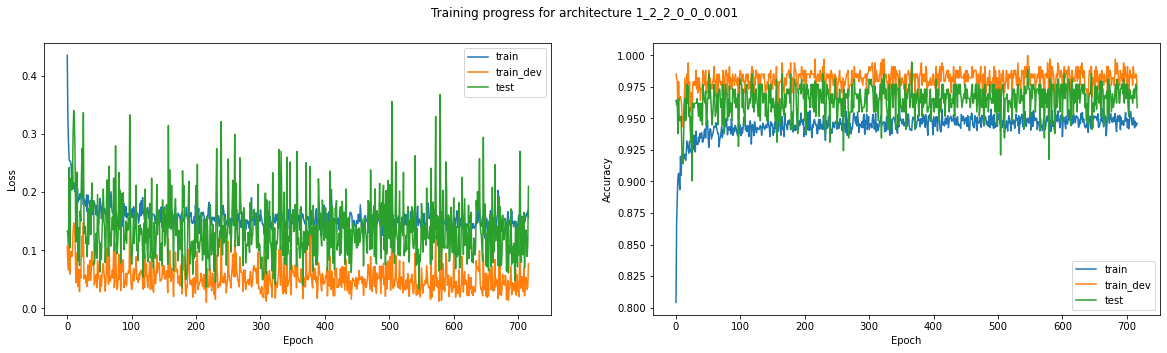

2_32_1_1_16_0.0001


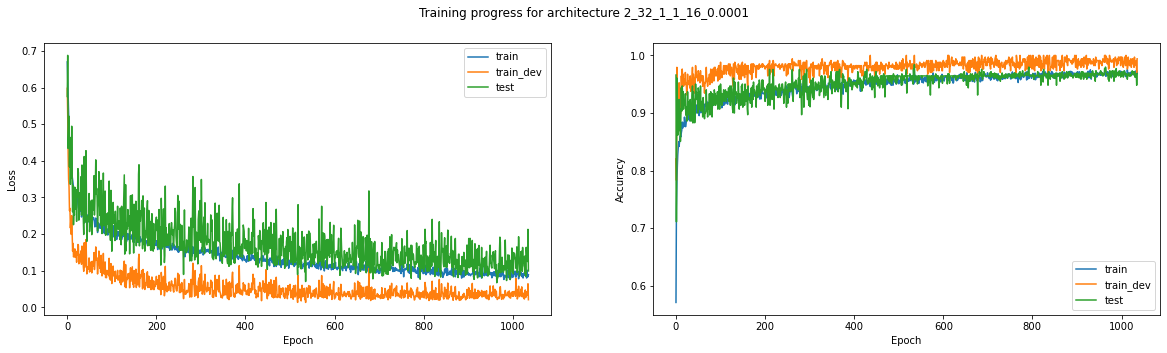

1_2_2_1_16_1e-05


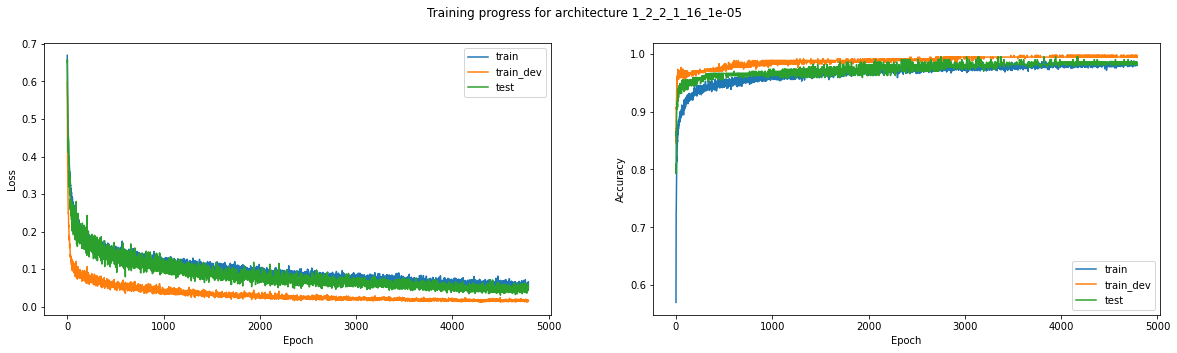

2_32_1_0_0_1e-05


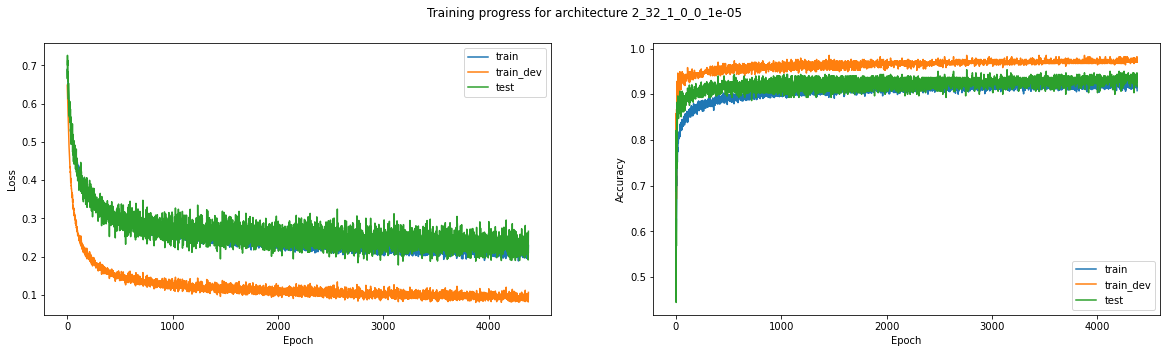

2_32_1_1_16_1e-06


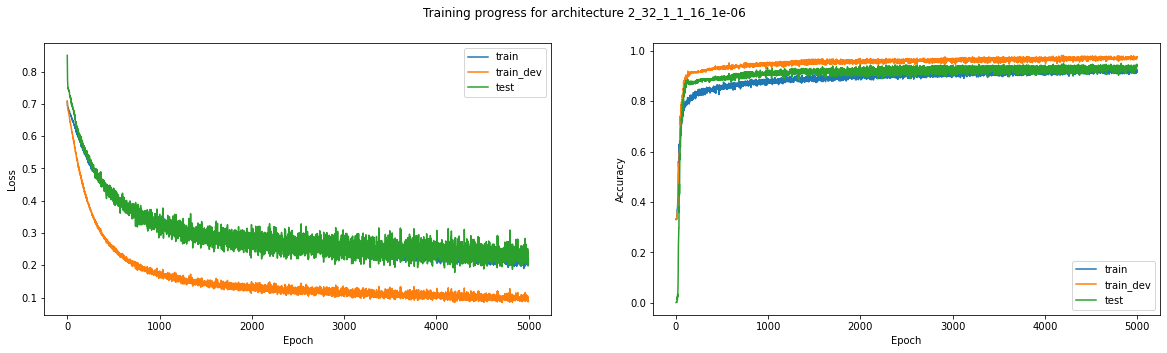

2_32_1_1_16_1e-05


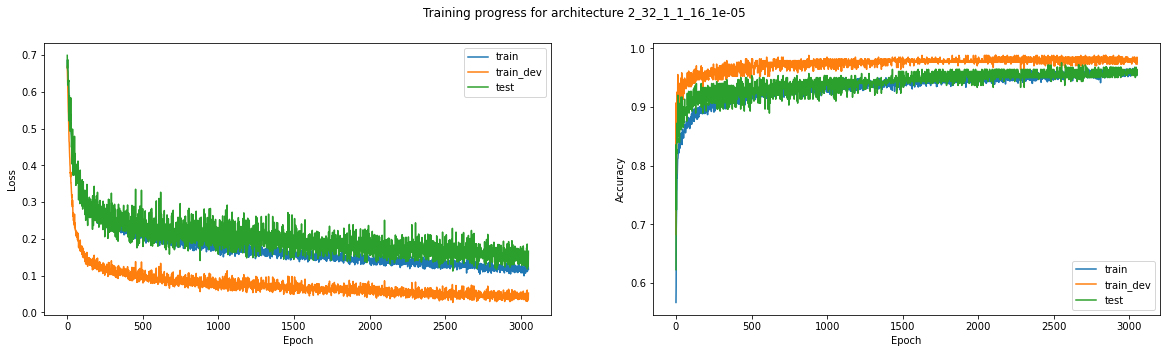

2_32_1_0_0_1e-06


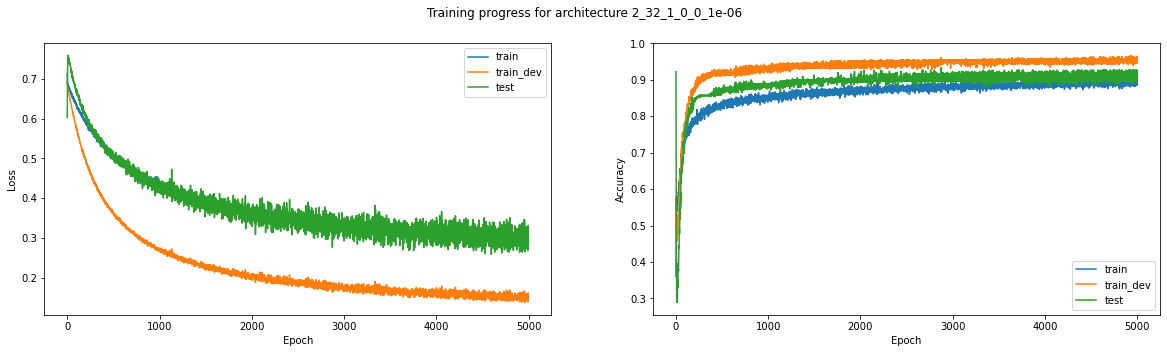

1_2_2_0_0_0.0001


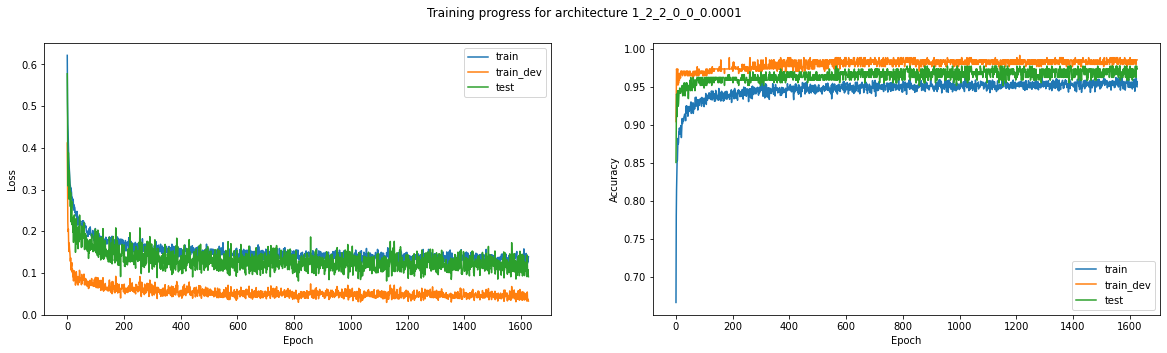

1_2_2_1_16_0.0001


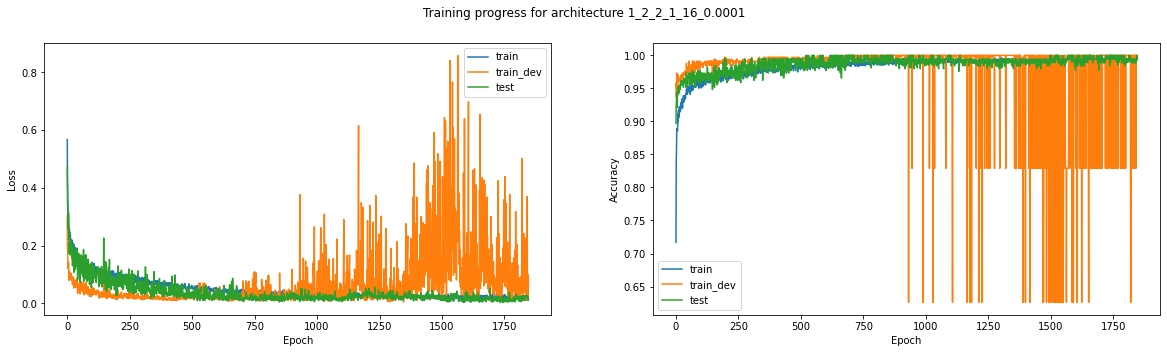

2_32_1_1_16_0.001


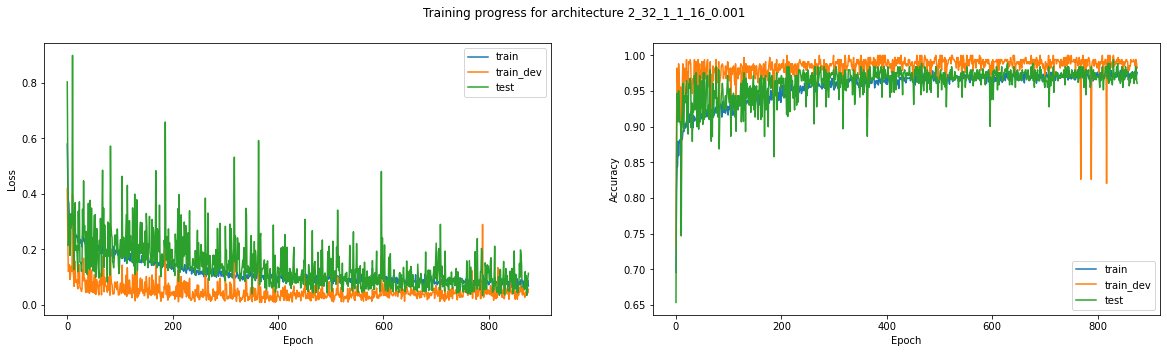

2_32_1_0_0_0.0001


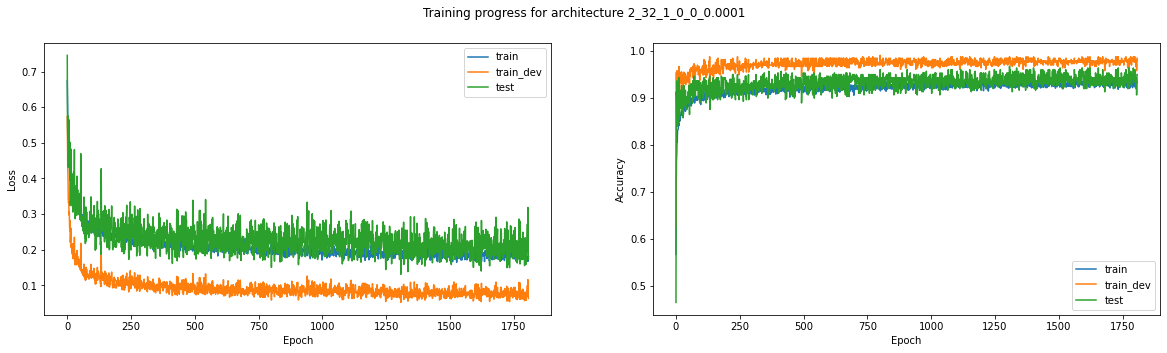

1_2_2_1_256_1e-06


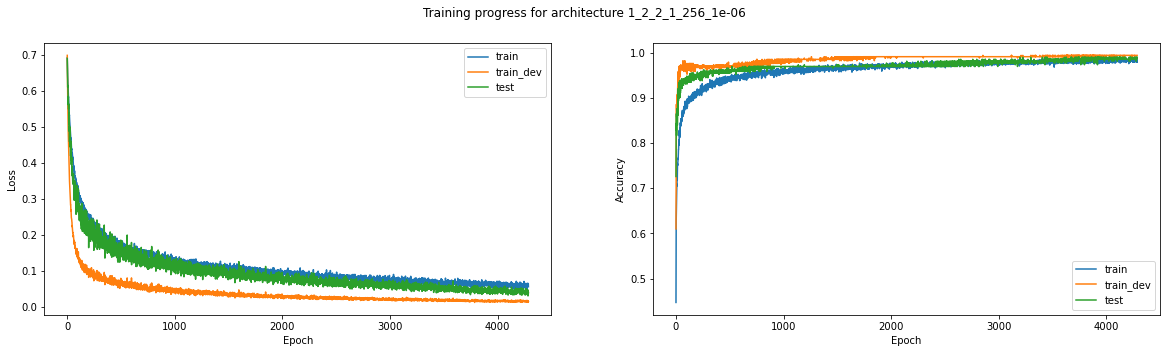

1_2_2_0_0_1e-06


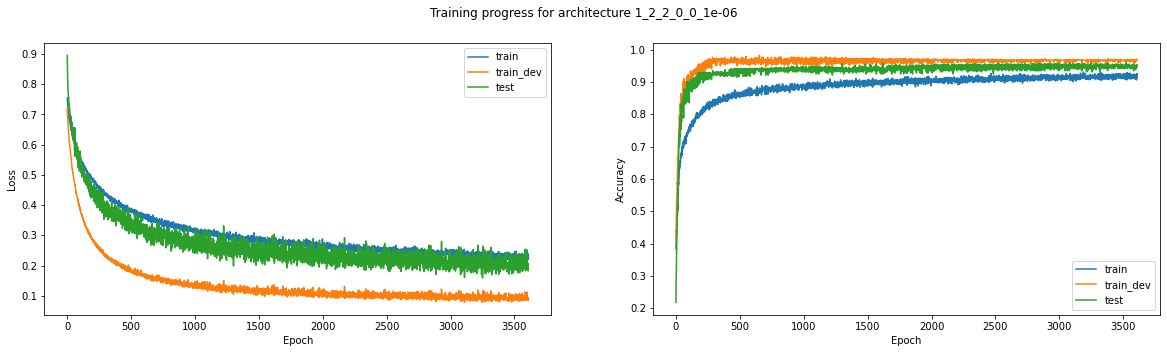

1_2_2_1_16_0.001


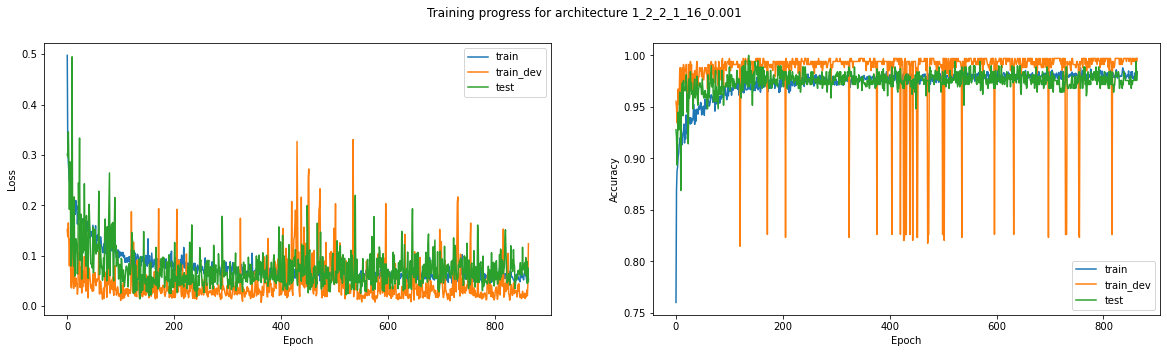

1_2_2_0_0_1e-05


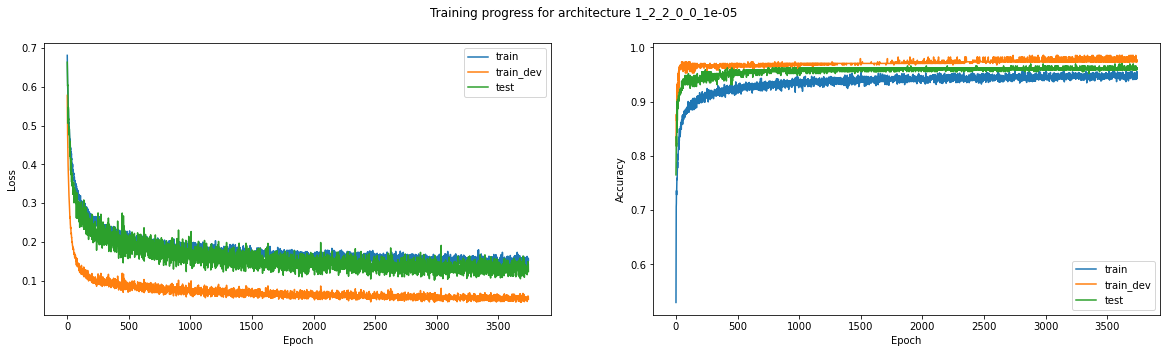

2_32_1_1_256_1e-05


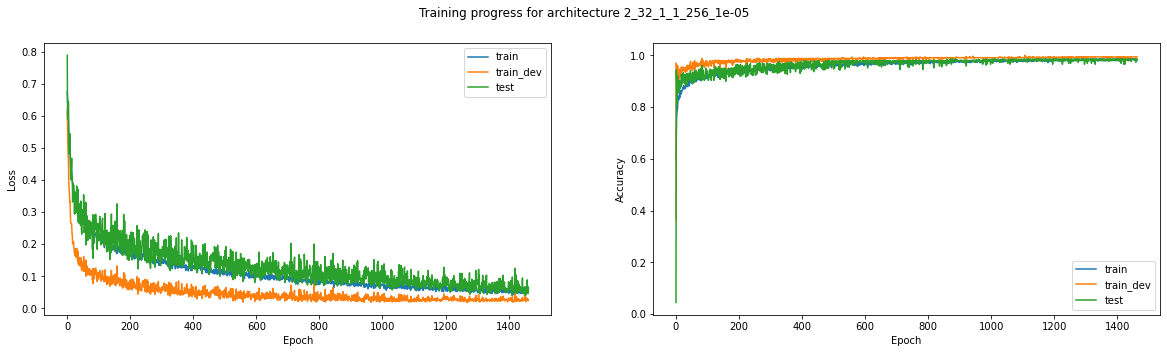

1_2_2_1_16_1e-06


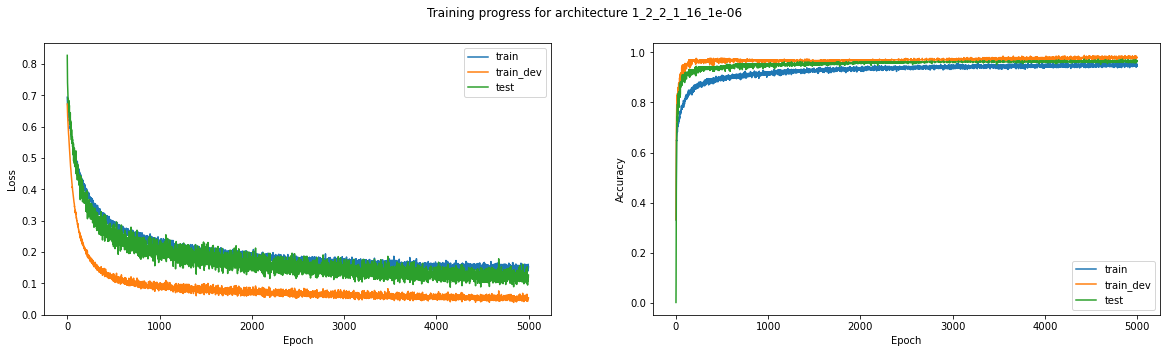

2_32_1_1_256_0.0001


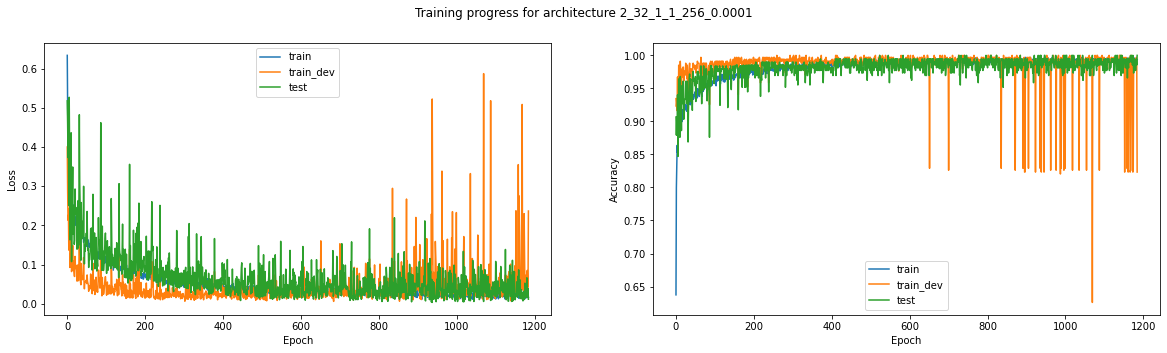

2_32_1_0_0_0.001


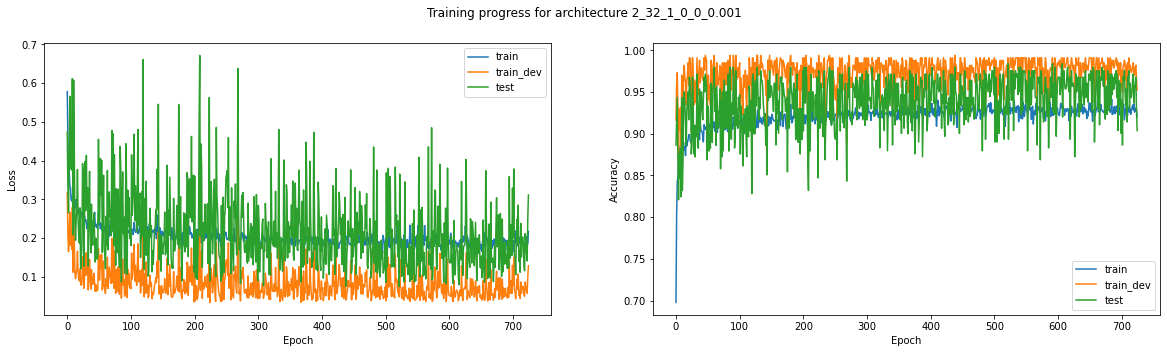

1_2_2_1_256_0.001


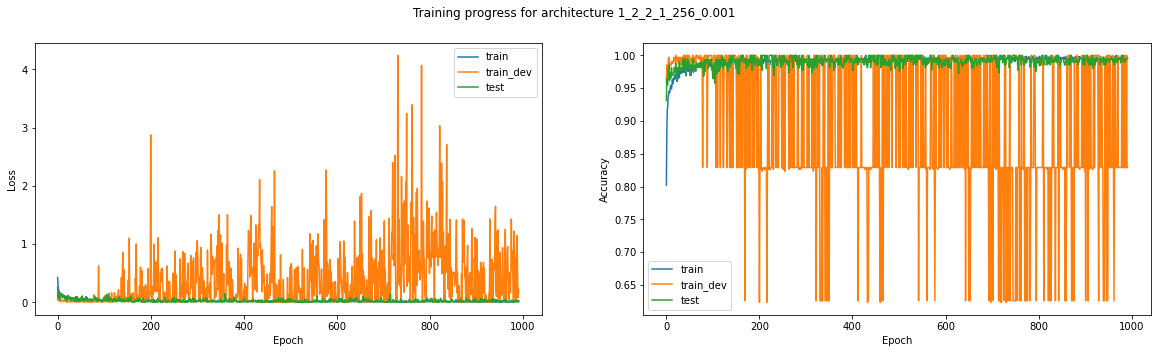

1_2_2_1_256_1e-05


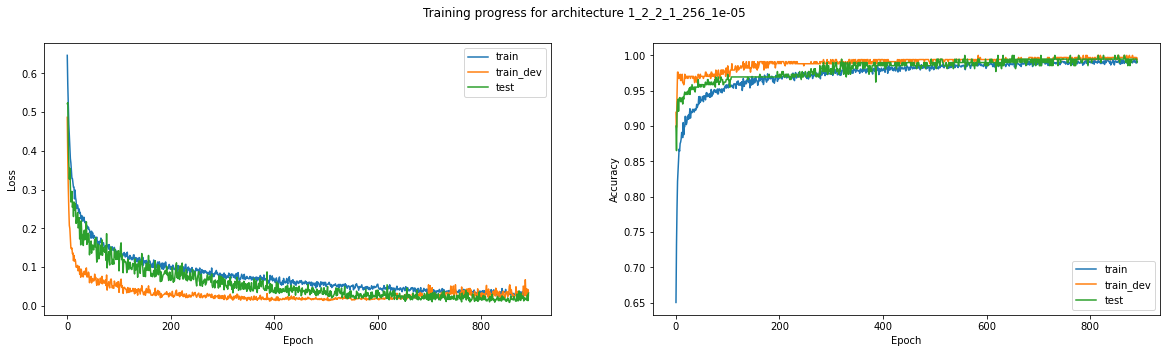

1_2_2_1_256_0.0001


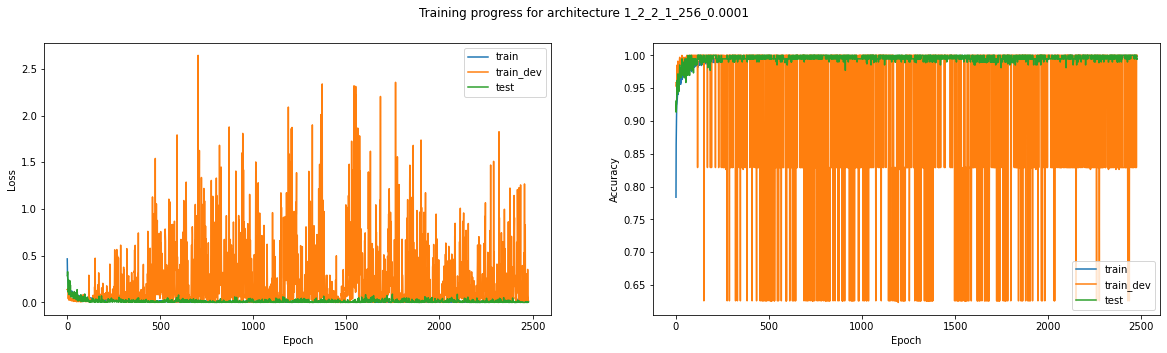

In [53]:
# Full retraining
networks=[os.path.basename(f) for f in glob.glob('../../1_Data/3_Trained_classifier_finetuning_classification/*')]
networks=networks[:-1]

#networks.remove('2_32_1_1_256_1e-06')

#print(networks)

for i in networks:
    print(i)
    plot_training('../../1_Data/3_Trained_classifier_finetuning_classification/'+i+'/',i)
    plt.show()

## GradCAM

In [38]:
def translate_group(index):
    
    if (index==0):
        return 'control'
    elif (index ==1):
        return 'albinism'

In [50]:
def plot_occlusion(folder_with_networks, dataloader, group_to_be_evaluated, slice_to_be_shown, architectures=None):
    
    if architectures==None:
        networks = [os.path.basename(x[0]) for x in os.walk(folder_with_networks)]
        networks=networks[1:]
    else:
        networks=architectures
    
    # Fetch data used for evaluation
    batch=next(enumerate(dataloader[group_to_be_evaluated]))[1]
    
    for network in networks:#[0:1]:
        
        print(network)
        
        # Initialize the model
        params=network.split('_')

        model = Classifier(int(params[0]),int(params[1]),int(params[2]),int(params[3]),int(params[4]))
        model.load_state_dict(torch.load(folder_with_networks+network+'/optimal_weights'))
        
        # Calculate the accuracy
        prediction = model(batch['chiasm']['data']).squeeze()
        accuracy = accuracy_score(batch['label'],prediction.detach().cpu().numpy().round())
        print(accuracy)
        
        # Plot the explanation provided by occlusion model
        occlusion = Occlusion(model)
        
        plt.figure(figsize=(7,20))
        plt.suptitle('Explanation of predictions')
        
        print(batch['chiasm']['data'].shape)
        
        for i in range(len(batch['label'])):
            
            input=batch['chiasm']['data'][i].unsqueeze(0)
                        
            attributions_occ_zero = occlusion.attribute(input,
                                       target=0,
                                       sliding_window_shapes=(1,3,3,1),
                                       baselines=0)
            
            # original image
            plt.subplot(len(batch['label']),2,2*i+1)
            plt.imshow(batch['chiasm']['data'][i:(i+1)][0,0,:,:,3], cmap='gray', alpha=1)    
            plt.xlabel(translate_group(batch['label'][i]))
            plt.tick_params(axis='both', labelsize=0, length = 0)
            if(i==0):
                plt.title('Selected slice from chosen image')       
            
            # explanation for control           
            plt.subplot(len(batch['label']),2,2*i+2)
            plt.imshow(attributions_occ_zero[0,0,:,:,3], cmap='jet', alpha=1)    
            plt.tick_params(axis='both', labelsize=0, length = 0)
            plt.xlabel("Probability of albinism = {:.2f}".format(prediction[i].item()))
            if(i==0):
                plt.title('Regions driving the prediction')       
                
        plt.show()

2_32_1_1_16_0.001
0.8571428571428571
torch.Size([7, 1, 24, 24, 8])


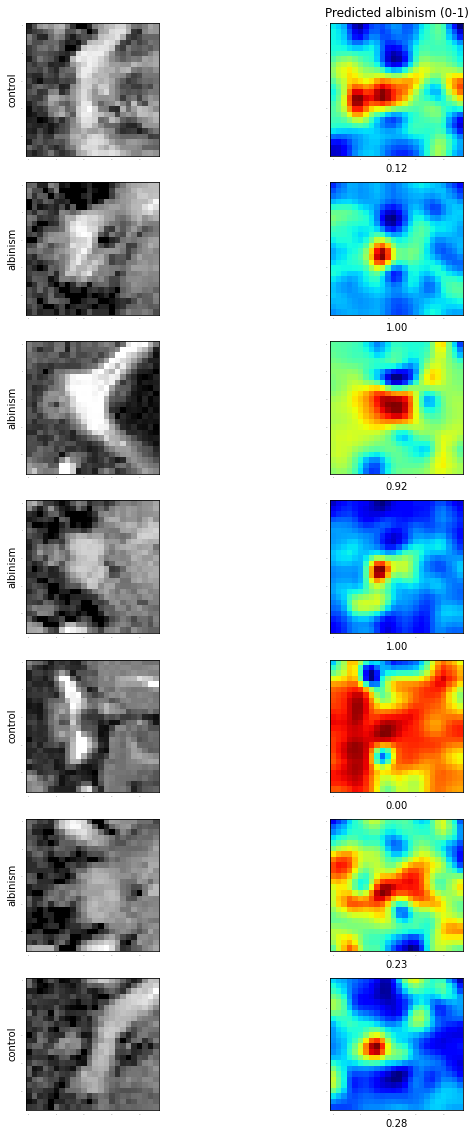

In [41]:
# Full retraining
#plot_gradcam('../../1_Data/3_Trained_classifier_full_retraining/',dataloaders_chiasm,'dev_test',3,['32_1_0_0_1e-06','32_1_1_32_0.0001','32_1_0_0_1e-05'])
# chosen 32_1_0_0_1e-06
plot_occlusion('../../1_Data/3_Trained_classifier_finetuning_classification/',dataloaders_chiasm,'test',4,['2_32_1_1_16_0.001'])

1_2_2_1_256_1e-05
1.0
torch.Size([7, 1, 24, 24, 8])


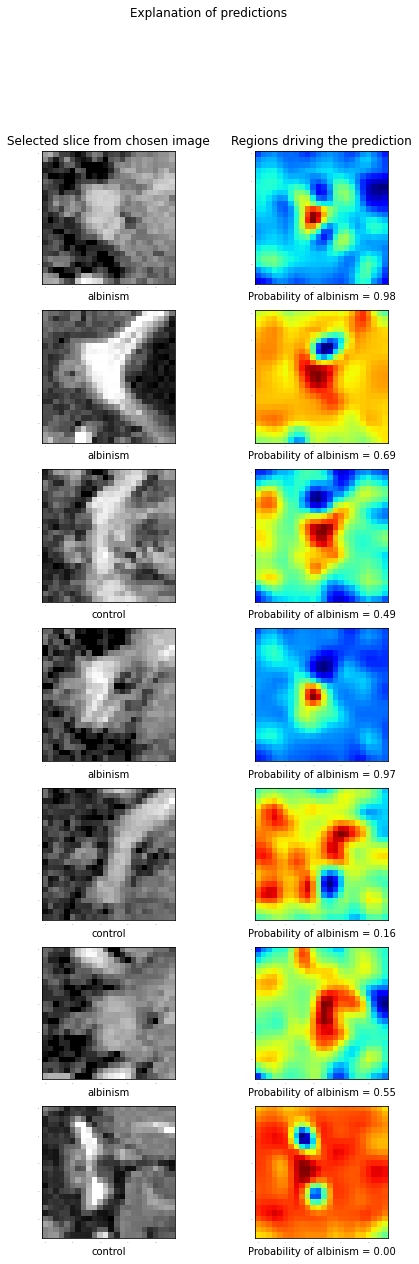

In [51]:
# Full retraining
plot_occlusion('../../1_Data/3_Trained_classifier_finetuning_classification/',dataloaders_chiasm,'test',2,['1_2_2_1_256_1e-05'])

# Performance on averaged data

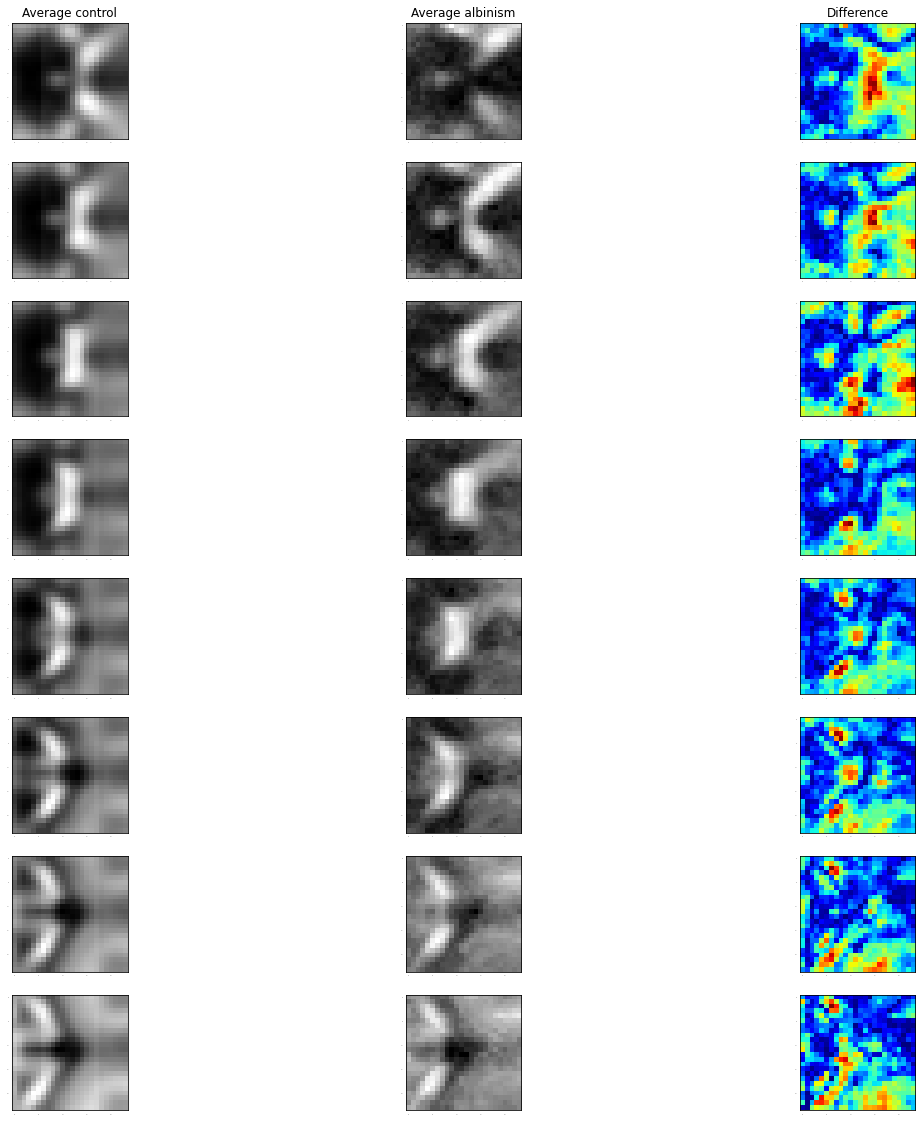

In [23]:
# Calculate average input

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))
average_other = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:    
    average_control+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==1], axis=(0,1))
    
average_control /= np.max(average_control)
average_albinism /= np.max(average_albinism)

plt.figure(figsize=(20,20))

for i in range(8):
        
    # Control
    plt.subplot(8,3,3*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average control')
    
    # Albinism
    plt.subplot(8,3,3*i+2)
    plt.imshow(average_albinism[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average albinism')
        
    # Difference
    plt.subplot(8,3,3*i+3)
    plt.imshow(np.abs(average_control[:,:,i]-average_albinism[:,:,i]), cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Difference')


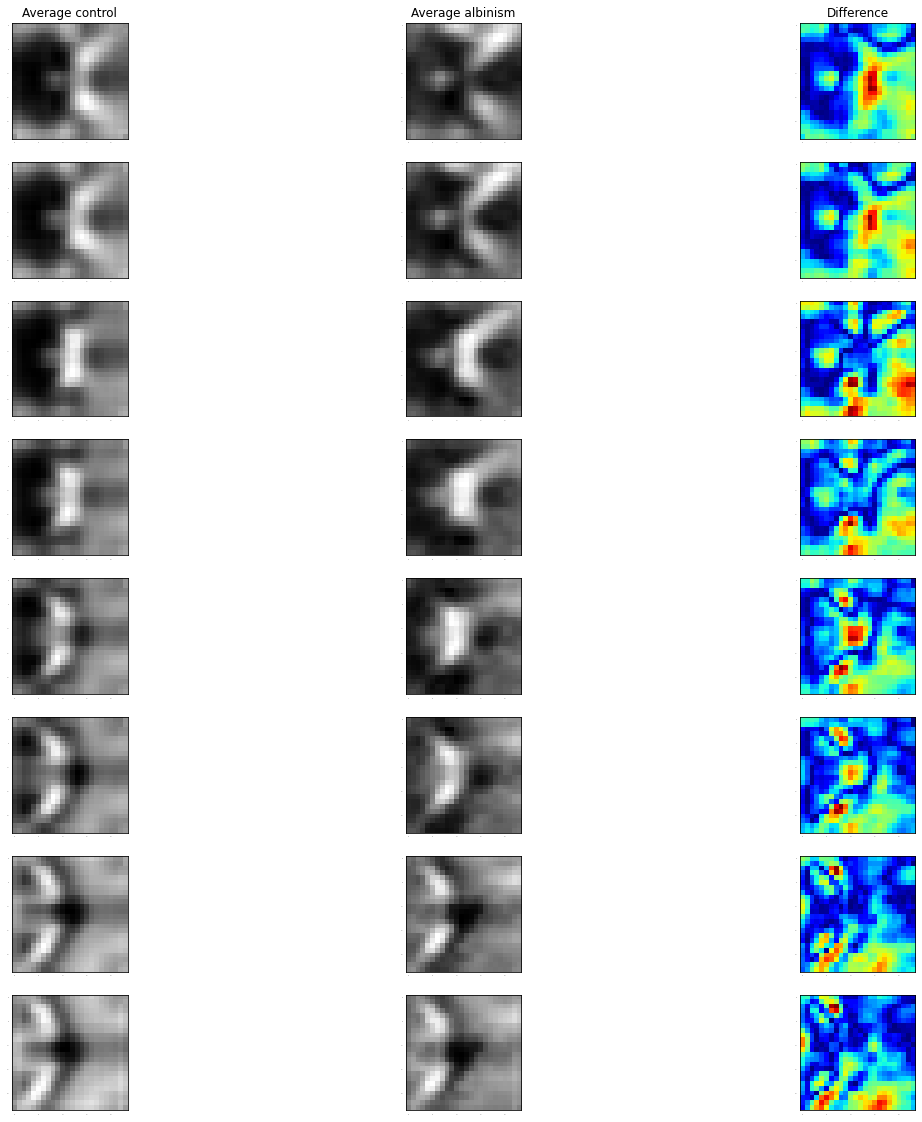

In [24]:
# Calculate average input after AE step

ae = UNet_1_layer(1,1,2,2)
ae.load_state_dict(torch.load('../../1_Data/2_Trained_AE/1_layer_2_2/optimal_weights'))

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))
average_other = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:  
                              
    output = ae(batch['chiasm']['data']).detach().numpy()                
                                                       
    average_control+=np.sum(output[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(output[batch['label'].numpy()==1], axis=(0,1))
    average_other+=np.sum(output[batch['label'].numpy()==2], axis=(0,1))
    
average_control /= np.max(average_control)
average_albinism /= np.max(average_albinism)

plt.figure(figsize=(20,20))

for i in range(8):
        
    # Control
    plt.subplot(8,3,3*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average control')
    
    # Albinism
    plt.subplot(8,3,3*i+2)
    plt.imshow(average_albinism[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average albinism')
        
    # Difference
    plt.subplot(8,3,3*i+3)
    plt.imshow(np.abs(average_control[:,:,i]-average_albinism[:,:,i]), cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Difference')


# Explanations with captum

## Showcase on CIFAR

In [24]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import visualization as viz

In [56]:
# Works beautifully!
model = Classifier(1,2,2,1,256)
model.load_state_dict(torch.load('../../1_Data/3_Trained_classifier_finetuning_classification/1_2_2_1_256_1e-05/optimal_weights'))

<All keys matched successfully>

In [57]:
for batch in dataloaders_chiasm['test']:
    print('Works')

Works


In [58]:
# Atribution algorithms on chosen input
ind=0

input = batch['chiasm']['data'][ind].unsqueeze(0)
input.requires_grad = True

In [59]:
# Set model in evaluation mode
model.eval();

In [60]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [61]:
# computes gradients with respect to target class and transposes them for visualization purposes.
saliency = Saliency(model)
grads = saliency.attribute(input, target=labels[ind].item())

In [62]:
# Applies integrated gradients attribution algorithm on test image. Integrated Gradients computes the integral of the gradients of the output prediction for the class index ind with respect to the input image pixels. More details about integrated gradients can be found in the original paper
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0181], dtype=torch.float64)


In [63]:
# Below we demonstrate how to use integrated gradients and noise tunnel with smoothgrad square option on the test image. Noise tunnel with smoothgrad square option adds gaussian noise with a standard deviation of stdevs=0.2 to the input image nt_samples times, computes the attributions for nt_samples images and returns the mean of the squared attributions across nt_samples images.
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)

In [64]:
# Applies DeepLift on test image. Deeplift assigns attributions to each input pixel by looking at the differences of output and its reference in terms of the differences of the input from the reference.
dl = DeepLift(model)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)

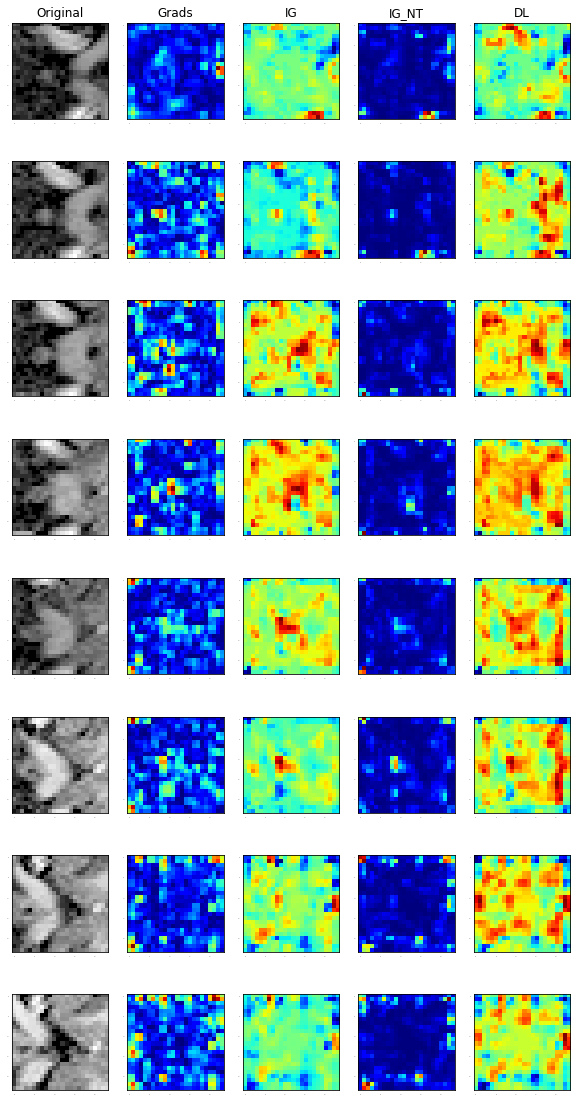

In [65]:
fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],5,5*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
    
    plt.subplot(input.shape[4],5,5*i+2)
    plt.imshow(grads.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Grads')
    
    plt.subplot(input.shape[4],5,5*i+3)
    plt.imshow(attr_ig.detach().numpy()[0,0,:,:,i],cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG')
        
    plt.subplot(input.shape[4],5,5*i+4)
    plt.imshow(attr_ig_nt.detach().numpy()[0,0,:,:,i],cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG_NT')
    
    plt.subplot(input.shape[4],5,5*i+5)
    plt.imshow(attr_dl.detach().numpy()[0,0,:,:,i],cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('DL')


## Pretrained ResNet model

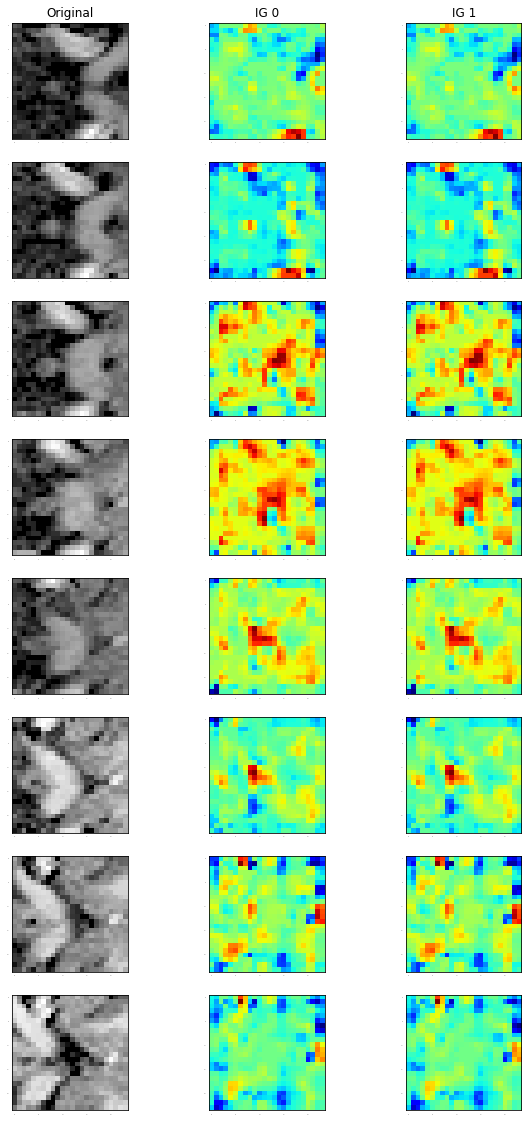

In [66]:
# Integrated gradients
integrated_gradients = IntegratedGradients(model)
attributions_ig_zero = integrated_gradients.attribute(input, target=0, n_steps=200)
attributions_ig_one = integrated_gradients.attribute(input, target=0, n_steps=200)

fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],3,3*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
        
    plt.subplot(input.shape[4],3,3*i+2)
    plt.imshow(attributions_ig_zero.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG 0')
        
    plt.subplot(input.shape[4],3,3*i+3)
    plt.imshow(attributions_ig_one.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG 1')

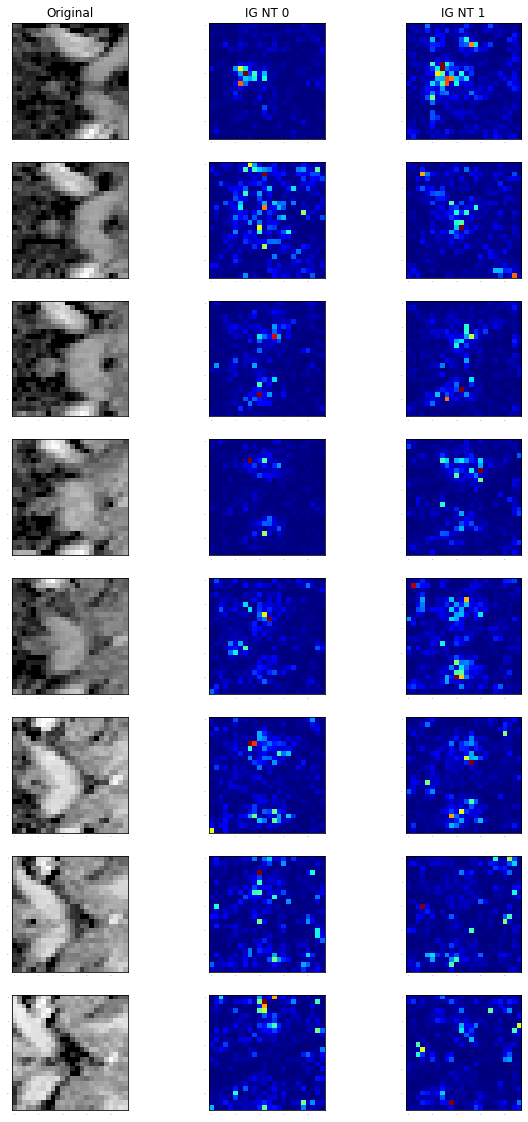

In [67]:
# IG + Noise Tunnel
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt_zero = noise_tunnel.attribute(input, nt_samples=20, nt_type='smoothgrad_sq', target=0)
attributions_ig_nt_one = noise_tunnel.attribute(input, nt_samples=20, nt_type='smoothgrad_sq', target=0)

fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],3,3*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
        
    plt.subplot(input.shape[4],3,3*i+2)
    plt.imshow(attributions_ig_nt_zero.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG NT 0')
        
    plt.subplot(input.shape[4],3,3*i+3)
    plt.imshow(attributions_ig_nt_one.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG NT 1')

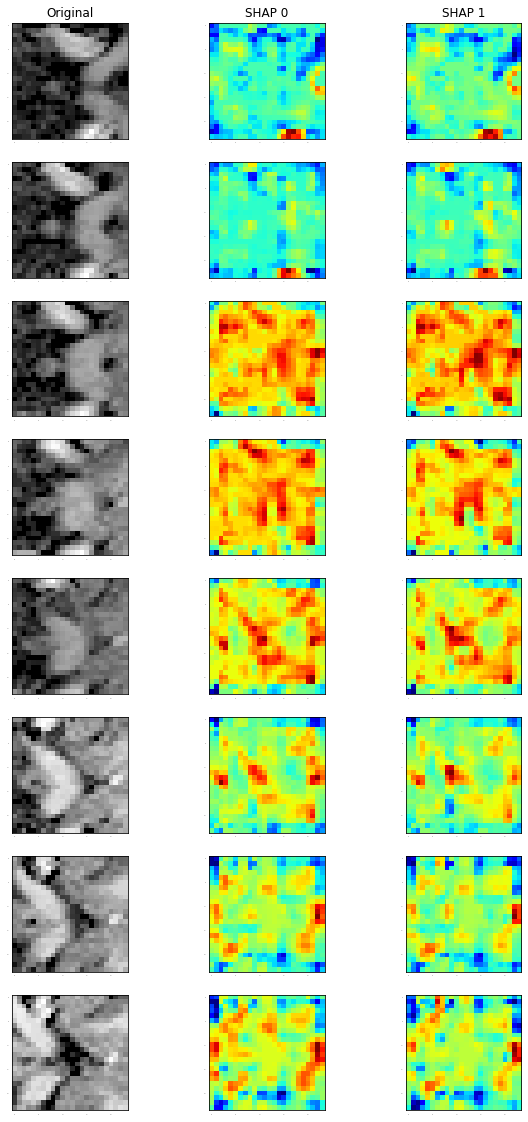

In [68]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs_zero = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=0)

attributions_gs_one = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=0)

fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],3,3*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
        
    plt.subplot(input.shape[4],3,3*i+2)
    plt.imshow(attributions_gs_zero.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('SHAP 0')
        
    plt.subplot(input.shape[4],3,3*i+3)
    plt.imshow(attributions_gs_one.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('SHAP 1')

In [69]:
# Occlusion
occlusion = Occlusion(model)

attributions_occ_zero = occlusion.attribute(input,
                                       target=0,
                                       sliding_window_shapes=(1,2,2,1),
                                       baselines=0)


attributions_occ_one = occlusion.attribute(input,
                                       target=0,
                                       sliding_window_shapes=(1,2,2,1),
                                       baselines=0)

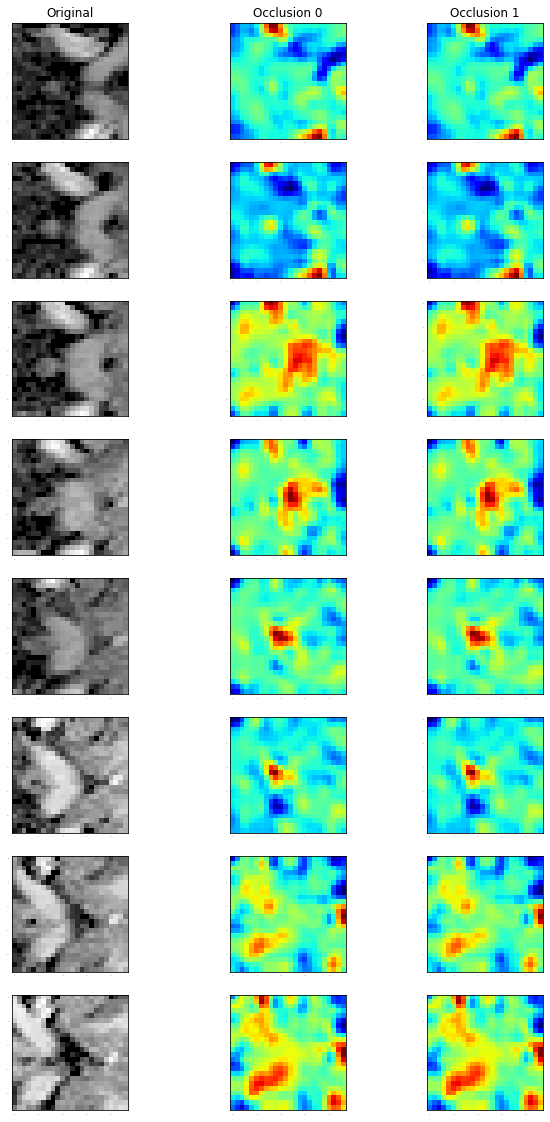

In [70]:
fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],4,4*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
                
    plt.subplot(input.shape[4],3,3*i+2)
    plt.imshow(attributions_occ_zero.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Occlusion 0')
        
    plt.subplot(input.shape[4],3,3*i+3)
    plt.imshow(attributions_occ_one.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Occlusion 1')